In [1]:
from sys import path
path.append('../')

In [2]:
data_path: str = "../data.nosync/dataset_smile_challenge.npy"

# Exploration

In [3]:
from numpy import load, fromiter, ndarray
from seaborn import countplot
from matplotlib.pyplot import (
    ylabel as set_ylabel,
    xlabel as set_xlabel,
    title as plot_title,
    show as show_fig,
    savefig
)
from src.utils.vizualizations import add_text_barplot

In [4]:
data: dict = load(data_path, allow_pickle=True).item()

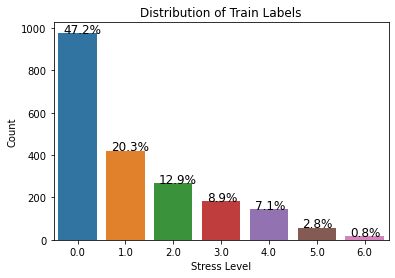

In [5]:
ax = countplot(x=data['train']['labels'])
set_ylabel("Count")
set_xlabel("Stress Level")
plot_title("Distribution of Train Labels")
add_text_barplot(ax, data['train']['labels'], 0.3)
savefig('../visualizations/distribution_train_labels.pdf')
show_fig()

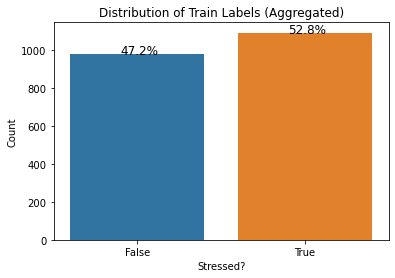

In [6]:
train_labels_aggregatored: ndarray = fromiter(
    (0 if label == 0 else 1 for label in data["train"]["labels"]), bool
)


ax = countplot(x=train_labels_aggregatored)
set_ylabel("Count")
set_xlabel("Stressed?")
plot_title("Distribution of Train Labels (Aggregated)")
add_text_barplot(ax, train_labels_aggregatored, 0.1)

savefig("../visualizations/distribution_train_labels_aggregated.pdf")
show_fig()


From the distribution plots, a few simple conclusions can be made:
1. If we use a **binary** classification, the classes are almost equally distributed: in this case, it probably is not necessary to apply any "rebalancing" or similar.
2. If we use a **multiclass** classification, the classes are not equally distributed: in this case, it is important to figure out what to do with it.

In [7]:
from IPython.display import display, Markdown as md

display(md("Dimension of features in train set"))
for feature_class_keys in data['train'].keys():
    display(md(f"## {feature_class_keys}"))    
    if isinstance(data['train'][feature_class_keys], dict):
        for feature_keys in data['train'][feature_class_keys].keys():
            display(md(f"\t\t{feature_keys}: {data['train'][feature_class_keys][feature_keys].shape}"))
    else:
        display(md(f"\t\t{data['train'][feature_class_keys].shape}"))

Dimension of features in train set

## deep_features

		ECG_features_C: (2070, 60, 256)

		ECG_features_T: (2070, 60, 64)

		masking: (2070, 60)

## hand_crafted_features

		ECG_features: (2070, 60, 8)

		GSR_features: (2070, 60, 12)

		ECG_masking: (2070, 60)

		GSR_masking: (2070, 60)

## labels

		(2070,)

In [19]:
import sys
import numpy
from numpy import sum
numpy.set_printoptions(threshold=sys.maxsize)
# print(data['train']['hand_crafted_features']['ECG_masking'])
# print(sum(data['train']['hand_crafted_features']['ECG_masking'], axis=1))
print(sum(sum(data['train']['hand_crafted_features'][ 'GSR_masking'], axis=1) < 60))

272


# Missing Values

Apparently, there are some missing values in the hand-crafter features. Here there is some exploration as to how big the problem is, what could be done and others.

In [13]:
from IPython.display import display, Markdown as md
from numpy import isnan


display(md("Dimension of features in train set"))
for feature_class_keys in data['train'].keys():
    display(md(f"## {feature_class_keys}"))    
    if isinstance(data['train'][feature_class_keys], dict):
        for feature_keys in data['train'][feature_class_keys].keys():
            try:
                display(md(f"\t\t{feature_keys}: {sum(sum(sum(isnan(data['train'][feature_class_keys][feature_keys]))))}"))
            except Exception as e:
                display(md(f"\t\t{feature_keys}: {(sum(sum(isnan(data['train'][feature_class_keys][feature_keys]))))}"))
    else:
        display(md(f"\t\t{(sum(isnan(data['train'][feature_class_keys])))}"))

Dimension of features in train set

## deep_features

		ECG_features_C: 0

		ECG_features_T: 0

		masking: 0

## hand_crafted_features

		ECG_features: 111

		GSR_features: 0

		ECG_masking: 0

		GSR_masking: 0

## labels

		0

There are 111 values in the ECG features which are NaN. As such, a more thorough investigation of them shall be performed.

In [49]:
from numpy import sum as ndarray_sum, isnan, nonzero, array

data_w_nan: ndarray = data["train"]["hand_crafted_features"]["ECG_features"]
ecg_features_names: list[str] = [
    "mean heart rate",
    "std HRV R-R",
    "RMSE R-R diff",
    "low freq",
    "high freq",
    "ratio low/high freq",
    "ratio very low/low freq",
    "HR cycle",
]
ecg_features_names: ndarray = array(ecg_features_names)
display(md("### ECG features w/ NaN"))
nan_col_idx: tuple[ndarray, None] = nonzero(ndarray_sum(ndarray_sum(isnan(data_w_nan), axis=1), axis=0))
for el in ecg_features_names[nan_col_idx]:
    print(f'-- {el}')

### ECG features w/ NaN

-- mean heart rate
-- low freq
-- ratio low/high freq
-- HR cycle


The NaN values are not present in all of the features, but only on the indicated ones. As such, let's see more in detail.

[1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 2 2 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 2 1 3 0 0 0 1 0 0 1 1 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 2 0 1 0 0 0 1 0 0 1 1 0 0 1]
[2 3 0 0 3 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0
 0 0 0 1 0 0 0 0 0 0 1 1 1 2 1 1 2 2 1 1 4 2 2]
[0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 2 1 1 0 0 0 1 0 0 1 1 1 0 1]


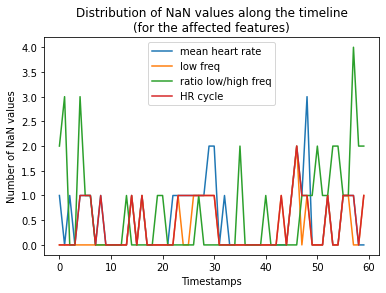

In [55]:
from matplotlib.pyplot import plot, show, legend, title, xlabel, ylabel

if len(nan_col_idx) == 1:
    nan_col_idx: ndarray = nan_col_idx[0]
else:
    pass
for feat in nan_col_idx:
    missing_timestamps: ndarray = ndarray_sum(isnan(data_w_nan[:,:,feat]), axis=0)
    print(missing_timestamps)
    plot(missing_timestamps, label=ecg_features_names[feat])
legend()
title("Distribution of NaN values along the timeline\n(for the affected features)")
xlabel("Timestamps")
ylabel("Number of NaN values")
show()

The final step is to see which users have these NaN. Indeed, the values are not a lot, and as such it may belong to just a small class of users. What to do with them, or with these features, is something important to be discussed.

In [58]:
isnan(data_w_nan).shape

(2070, 60, 8)

In [59]:
nan_user_idx: tuple[ndarray, None] = nonzero(ndarray_sum(ndarray_sum(isnan(data_w_nan), axis=1), axis=1))

436 [1 0 0 0 0 0 0 0]
592 [2 0 0 2 0 0 0 2]
1853 [0 0 0 0 0 2 0 0]
1855 [0 0 0 0 0 2 0 0]
1856 [1 0 0 0 0 0 0 0]
1857 [1 0 0 0 0 0 0 0]
1890 [0 0 0 0 0 1 0 0]
1901 [3 0 0 2 0 0 0 3]
1932 [13  0  0  7  0 11  0 13]
1934 [0 0 0 0 0 1 0 0]
1938 [1 0 0 1 0 0 0 1]
1941 [0 0 0 0 0 1 0 0]
1942 [0 0 0 0 0 1 0 0]
1943 [0 0 0 0 0 1 0 0]
1944 [0 0 0 0 0 1 0 0]
1945 [0 0 0 0 0 1 0 0]
1947 [0 0 0 0 0 1 0 0]
1949 [0 0 0 0 0 3 0 0]
1953 [1 0 0 1 0 1 0 1]
1971 [1 0 0 0 0 1 0 1]
2002 [1 0 0 0 0 1 0 0]
2003 [3 0 0 1 0 0 0 1]
2004 [1 0 0 1 0 2 0 1]
2006 [0 0 0 0 0 1 0 0]
2008 [1 0 0 1 0 3 0 1]
2012 [1 0 0 1 0 0 0 1]
2014 [0 0 0 0 0 1 0 0]
2015 [0 0 0 0 0 1 0 0]
2025 [0 0 0 0 0 1 0 0]


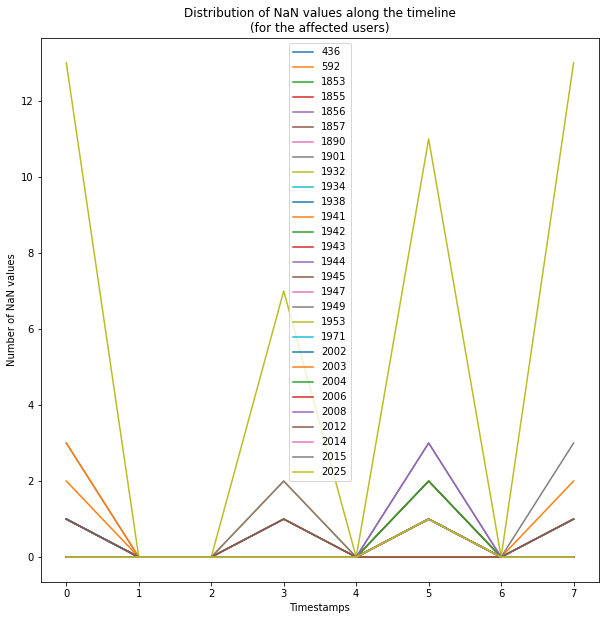

In [68]:
from matplotlib.pyplot import plot, show, legend, title, xlabel, ylabel, figure

figure(figsize=(10, 10))

if len(nan_user_idx) == 1:
    nan_user_idx: ndarray = nan_user_idx[0]
else:
    pass
for user in nan_user_idx:
    missing_timestamps: ndarray = ndarray_sum(isnan(data_w_nan[user,:,:]), axis=0)
    print(user, missing_timestamps)
    plot(missing_timestamps, label=user)
legend()
title("Distribution of NaN values along the timeline\n(for the affected users)")
xlabel("Timestamps")
ylabel("Number of NaN values")
show()

Most users have a very limited amount of NaNs, e.g. 2 or 3. On the other hand, user 1932 has a larger amount, in the range of 20. As such, it could be considered worthy to investigate weather to exclude this user from the analysis. 

On another note, it is important to consider how to deal with missing values. Since we have identified the presence of the problem, and can confirm that the fact that it is not widespread, we should consider possible solutions:
1. Remove the users with missing values
2. Remove the features with missing values
3. Input missing values w/ various techniques
    1. Simple rule-based. e.g. average
    2. ML-based -> much more complicated, since there is also need for training!
4. Others?

# Questions

We have a set of questions to pose to the challange organizers, which are listed here.

* What the "masking" features that are present in the dataset? 
* In the website, only 8 GSR features are described: however, the challange has 12. What are these?
* Is it possible to know which features are which? Indeed, are they ordered as described on the website? (Obviously for the hand-crafter features, since for the others it does not make any sense)

# Simple ML-models

Concatenation techniques for traditional machine learning: for each label, we have (N, 60,X). We can do:
1. Concatenate; so we have $(N, 60 \times X)$
2. Aggregate (with average), so we have $(N, 12)$
3. Give to each minute the label, so we have now $(N\times 60, 12)$

# Stuff to do

1. Feature extraction
2. Try combinations of sensors (but keep hand and deep separated)
3. Try different ML-models
4. Maybe put some undersampling or oversampling (`smote` for oversampling and `rus` for undersampling)

In [6]:
test = data['train']['hand_crafted_features']['ECG_features']

In [7]:
from numpy import apply_along_axis, ndarray, nanmean, nan_to_num, apply_over_axes
from numpy_indexed import group_by

def fill_mean(arr: ndarray) -> ndarray:
    mean: ndarray = nanmean(arr)
    return nan_to_num(arr, nan=mean)


for user in range(test.shape[0]):
    for feat in range(test.shape[2]):
        test[user,:,feat] = fill_mean(test[user,:,feat])

In [38]:
from numpy import array, nan

a = array([nan,3,4,4,3,nan, 5])

In [35]:
from numpy import isnan, where, fromiter
from scipy.stats import mode
# ffill along axis 1, as provided in the answer by Divakar
def ffill(arr):
    mask = isnan(arr)
    idxs = array(where(mask))[0]
    for idx in idxs:
        arr[idx] = arr[idx-1] if idx > 0 else nanmean(arr)
    return arr

def filling_mode(arr: ndarray) -> ndarray:
    return nan_to_num(arr, nan=mode(arr)[0][0])

In [43]:
mode(a)[0][0]

3.0